In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
##read datasets
df=pd.read_pickle(r"cust_final_241019.pkl")

In [4]:
df.PRODUCT_GROUP.value_counts()

CD     135642
CL      38454
ACL      6941
TW        643
Name: PRODUCT_GROUP, dtype: int64

In [4]:
df.columns 

Index(['MOBILE', 'PRODUCT_GROUP', 'MEMBER_ID_nunique', 'ACTIVITY_ID_nunique',
       'ACTIVITY_VALUE_max', 'ACTIVITY_VALUE_min', 'ACTIVITY_VALUE_median',
       'ACTIVITY_VALUE_std', 'ACTIVITY_VALUE_mean', 'ALLOCATED_POINTS_max',
       ...
       'CLIENT_EXI_3M', 'TIME_DECISION_DATE', 'RISK_FPD30', 'RISK_AGRF30',
       'RISK_FSPD30', 'RISK_AGRF60', 'RISK_FSTPD30', 'RISK_AGRF90',
       'RISK_FSTQPD30', 'RISK_AGRF120'],
      dtype='object', length=566)

In [5]:
df.dropna(subset=['HC_SCORE'],inplace=True)

In [6]:
#df = df[(df['RISK_AGRF120']== 1) & (((df['PRODUCT_GROUP']=='CD') & (df['CLIENT_EXI_3M']=='Y')) | (df['PRODUCT_GROUP']=='CL')) ]

In [7]:
dfcd = df[(df['RISK_AGRF120']== 1) & (((df['PRODUCT_GROUP']=='CD') & (df['CLIENT_EXI_3M']=='Y')))]
dfcl = df[(df['RISK_AGRF120']== 1) & (df['PRODUCT_GROUP']=='CL')]

In [8]:
print(dfcd.shape)
print(dfcl.shape)

(49429, 566)
(27580, 566)


In [9]:
dfcd.reset_index(inplace=True)
dfcl.reset_index(inplace=True)

In [10]:
df = pd.concat([dfcd, dfcl], ignore_index=True, sort =False)

In [11]:
df.reset_index(inplace=True)

In [12]:
del(df['index'])
del(df['level_0'])

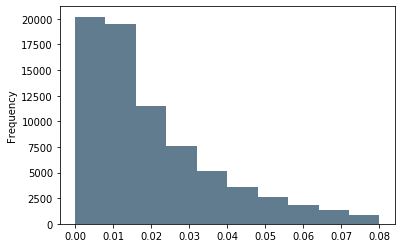

In [13]:
# Check distribution of scores
pd.Series(df['HC_SCORE']).plot.hist(bins=10, range=(0,0.08) ,color='#607c8e')

In [14]:
pg = df["PRODUCT_GROUP"]
X=df.drop(['MOBILE','RISK_AGRF30','RISK_FPD30','RISK_FSPD30','RISK_FSTPD30',
           'RISK_FSTQPD30','CLIENT_EXI_3M', 'TIME_DECISION_DATE_max', 'ACTIVITY_DATE_min', 'ACTIVITY_DATE_max', 
            'TIME_DECISION_DATE'] ,axis=1)
Y=df[['RISK_FSTQPD30']]

In [15]:
hcc_score='HC_SCORE'

# HCC score Gini         
y_hcc = dfcl[hcc_score]
df_hcc = pd.DataFrame({'true': np.ravel(dfcl["RISK_FSTQPD30"]), 'predict': y_hcc})
df_hcc = df_hcc.loc[pd.notnull(df_hcc['predict']),:]
metric_auc_hcc = metrics.roc_auc_score(df_hcc['true'], df_hcc['predict'])
gini_hcc_only = 2 * metric_auc_hcc - 1
print("HCIN SCORE GINI:" ,gini_hcc_only)

HCIN SCORE GINI: 0.17696640370408945


In [16]:
# split data into train and test sets
seed = 25522
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed,stratify = pg)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

y_test = y_test[X_test["PRODUCT_GROUP"]=='CL']
X_test = X_test[X_test["PRODUCT_GROUP"]=='CL']

X_valid.drop(columns= "PRODUCT_GROUP",inplace=True)
X_train.drop(columns= "PRODUCT_GROUP",inplace=True)
X_test.drop(columns= "PRODUCT_GROUP",inplace=True)
# X_train.drop('UW_SC',axis=1,inplace=True) 
# X_test.drop('UW_SC',axis=1,inplace=True) 

##event rate
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train.iloc[:,0]) / len(y_train.iloc[:,0])))
print("\n Train set shape:",X_train.shape)
print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test.iloc[:,0]) / len(y_test.iloc[:,0])))
print("\n Test set shape:",X_test.shape)
print("\nEvent rate in validation set :", '{:,.2%}'.format(sum(y_valid.iloc[:,0]) / len(y_valid.iloc[:,0])))
print("\n validation set shape:",X_valid.shape)
print("\n Train GINI",  metrics.roc_auc_score(y_train, X_train['HC_SCORE'])*2 -1)
print("\n Test GINI",  metrics.roc_auc_score(y_test, X_test['HC_SCORE'])*2 -1)
print("\n validation GINI",  metrics.roc_auc_score(y_valid, X_valid['HC_SCORE'])*2 -1)

## fecth original test data
train,test = train_test_split(dfcl, test_size=test_size, random_state=seed)
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(train['RISK_FSTQPD30']) / len(train.iloc[:,0])))
print("\n Train set shape:",train.shape)
print("\n Train GINI",  metrics.roc_auc_score(train['RISK_FSTQPD30'], train['HC_SCORE'])*2 -1)

print("\nEvent rate in test set :", '{:,.2%}'.format(sum(test['RISK_FSTQPD30']) / len(test.iloc[:,0])))
print("\n test set shape:",test.shape)
print("\n test GINI",  metrics.roc_auc_score(test['RISK_FSTQPD30'], test['HC_SCORE'])*2 -1)


Event rate in train set : 4.03%

 Train set shape: (41276, 554)

Event rate in test set : 3.05%

 Test set shape: (9101, 554)

Event rate in validation set : 4.06%

 validation set shape: (10320, 554)

 Train GINI 0.4025536712063227

 Test GINI 0.1433589612499051

 validation GINI 0.39837662548972275

Event rate in train set : 3.06%

 Train set shape: (18478, 567)

 Train GINI 0.17184296370510577

Event rate in test set : 2.97%

 test set shape: (9102, 567)

 test GINI 0.1879554146537843


In [17]:
X_test_pkl = X_test
X_test_pkl['RISK_FSTQPD30'] = y_test
X_test_pkl.to_pickle("clx\\pillar_test_set.pkl")

In [18]:
## Variable importance
def fimportances(xc, predictors):
    importances = pd.DataFrame({'predictor': predictors, 'importance': xc.feature_importances_})
    importances = importances[importances['importance'] > 0]
    importances.sort_values(by='importance', ascending=False, inplace=True)
    importances.reset_index(inplace=True, drop=True)
    importances = importances[['predictor', 'importance']]
    return importances

In [19]:
xgb_model = xgb.XGBClassifier(max_depth = 3,
              learning_rate= 0.01,
              subsample= 0.6,
              min_child_weight= 10,
              colsample_bytree= 0.6,
              scale_pos_weight =25,
              objective= 'binary:logistic', 
              nthread = -1, 
              n_estimators = 200              
              )

evals=[(X_train.drop(columns='HC_SCORE'), np.ravel(y_train)),(X_valid.drop(columns='HC_SCORE'), np.ravel(y_valid))]

bst = xgb_model.fit(X_train.drop(columns='HC_SCORE'), np.ravel(y_train), eval_metric="auc", eval_set=evals,
                    early_stopping_rounds=40   ,  verbose=False)

In [20]:
imp = fimportances(bst,X_train.drop(columns='HC_SCORE').columns)

In [21]:
bst1 = bst
X_train_1 = X_train.drop(columns='HC_SCORE')
X_valid_1 = X_valid.drop(columns='HC_SCORE')
select_X_train = X_train_1

dic_imp = {"n":[imp.shape[0]],"Gini Train":[0],"Gini Test":[0],"Predictors":[list(imp['predictor'])]}

while(select_X_train.shape[1] > 1):
    select_X_train = X_train_1[list(imp['predictor'])[:-2]]
    select_X_valid = X_valid_1[list(imp['predictor'])[:-2]]
    xgb_model = xgb.XGBClassifier(max_depth = 3,
              learning_rate= 0.01,
              subsample= 0.6,
              min_child_weight= 10,
              colsample_bytree= 0.6,
              scale_pos_weight =25,
              objective= 'binary:logistic', 
              nthread = -1, 
              n_estimators = 200              
              )

    evals=[(select_X_train, np.ravel(y_train)),(select_X_valid, np.ravel(y_valid))]

    bst = xgb_model.fit(select_X_train, np.ravel(y_train), eval_metric="auc", eval_set=evals,
                        early_stopping_rounds=40   ,  verbose=False)
    
    ypred_train = bst.predict_proba(select_X_train)[:, 1]
    ypred_test  = bst.predict_proba(select_X_valid)[:, 1]
    
    metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
    metric_auc_test = metrics.roc_auc_score(y_valid, ypred_test)

    gini_train = 2 * metric_auc_train - 1
    gini_test = 2 * metric_auc_test - 1
    
    print("Columns Remaining : %d , gini_train: %f,gini_test: %f "%(select_X_train.shape[1],gini_train,gini_test))
    
    dic_imp['n'].append(imp.shape[0])
    dic_imp['Gini Train'].append(gini_train)
    dic_imp['Gini Test'].append(gini_test)
    dic_imp['Predictors'].append(list(imp['predictor']))
    
    imp = fimportances(bst,select_X_train.columns)

Columns Remaining : 152 , gini_train: 0.290155,gini_test: 0.150103 
Columns Remaining : 134 , gini_train: 0.289468,gini_test: 0.145060 
Columns Remaining : 121 , gini_train: 0.291478,gini_test: 0.141970 
Columns Remaining : 111 , gini_train: 0.318020,gini_test: 0.155113 
Columns Remaining : 109 , gini_train: 0.230339,gini_test: 0.155266 
Columns Remaining : 89 , gini_train: 0.305097,gini_test: 0.148103 
Columns Remaining : 87 , gini_train: 0.226877,gini_test: 0.149509 
Columns Remaining : 76 , gini_train: 0.272816,gini_test: 0.161012 
Columns Remaining : 74 , gini_train: 0.277252,gini_test: 0.144433 
Columns Remaining : 70 , gini_train: 0.236418,gini_test: 0.151279 
Columns Remaining : 63 , gini_train: 0.262169,gini_test: 0.165701 
Columns Remaining : 60 , gini_train: 0.227051,gini_test: 0.163727 
Columns Remaining : 56 , gini_train: 0.277676,gini_test: 0.142525 
Columns Remaining : 54 , gini_train: 0.254513,gini_test: 0.143954 
Columns Remaining : 52 , gini_train: 0.226549,gini_test: 

In [22]:
df_imp =pd.DataFrame(dic_imp)

In [23]:
list(df_imp[df_imp['n']==42]["Predictors"])

[['ACTIVITY_DATE_nunique_E_WALLET_180_Burn',
  'mesdq_max',
  'ALLOCATED_POINTS_mean_E_WALLET_180_by_1000_Burn',
  'month_nunique_E_WALLET_180_by_1000_Burn',
  'ACTIVITY_VALUE_mean_FUEL_1000_Earn',
  'ACTIVITY_ID_count_E_WALLET_180_by_1000_Burn',
  'MOB',
  'month_nunique_E_WALLET_180_Burn',
  'ACTIVITY_VALUE_sum_FUEL_365_by_1000_Earn',
  'ALLOCATED_POINTS_sum_E_WALLET_180_by_1000_Burn',
  'month_nunique_GROCERY_1000_Earn',
  'ACTIVITY_VALUE_median_FUEL_1000_Earn',
  'ALLOCATED_POINTS_min_E_WALLET_365_Burn',
  'ALLOCATED_POINTS_sum_FUEL_1000_Earn',
  'month_nunique_E_WALLET_180_by_1000_Earn',
  'ACTIVITY_DATE_nunique_DEBIT_365_Earn',
  'month_nunique_DEBIT_1000_Earn',
  'ALLOCATED_POINTS_mean_FUEL_365_by_1000_Earn',
  'ACTIVITY_VALUE_sum_GROCERY_180_by_1000_Earn',
  'ALLOCATED_POINTS_sum_FUEL_365_by_1000_Earn',
  'ALLOCATED_POINTS_min_E_WALLET_180_Burn',
  'ACTIVITY_ID_count_FUEL_365_by_1000_Earn',
  'ALLOCATED_POINTS_EARN_LAG3',
  'ALLOCATED_POINTS_max_DEBIT_365_Earn',
  'ALLOCATED_PO

In [24]:
selected_vars = list(df_imp[df_imp['n']==42]["Predictors"])

In [25]:
selected_vars

[['ACTIVITY_DATE_nunique_E_WALLET_180_Burn',
  'mesdq_max',
  'ALLOCATED_POINTS_mean_E_WALLET_180_by_1000_Burn',
  'month_nunique_E_WALLET_180_by_1000_Burn',
  'ACTIVITY_VALUE_mean_FUEL_1000_Earn',
  'ACTIVITY_ID_count_E_WALLET_180_by_1000_Burn',
  'MOB',
  'month_nunique_E_WALLET_180_Burn',
  'ACTIVITY_VALUE_sum_FUEL_365_by_1000_Earn',
  'ALLOCATED_POINTS_sum_E_WALLET_180_by_1000_Burn',
  'month_nunique_GROCERY_1000_Earn',
  'ACTIVITY_VALUE_median_FUEL_1000_Earn',
  'ALLOCATED_POINTS_min_E_WALLET_365_Burn',
  'ALLOCATED_POINTS_sum_FUEL_1000_Earn',
  'month_nunique_E_WALLET_180_by_1000_Earn',
  'ACTIVITY_DATE_nunique_DEBIT_365_Earn',
  'month_nunique_DEBIT_1000_Earn',
  'ALLOCATED_POINTS_mean_FUEL_365_by_1000_Earn',
  'ACTIVITY_VALUE_sum_GROCERY_180_by_1000_Earn',
  'ALLOCATED_POINTS_sum_FUEL_365_by_1000_Earn',
  'ALLOCATED_POINTS_min_E_WALLET_180_Burn',
  'ACTIVITY_ID_count_FUEL_365_by_1000_Earn',
  'ALLOCATED_POINTS_EARN_LAG3',
  'ALLOCATED_POINTS_max_DEBIT_365_Earn',
  'ALLOCATED_PO

In [26]:
X_train_2=X_train[selected_vars[0]]
X_test_2=X_test[selected_vars[0]]
X_valid_2=X_valid[selected_vars[0]]


print("\n Train shape:",X_train_2.shape,"\n Test shape:",X_test_2.shape,"\n Validation shape:",X_valid_2.shape)


 Train shape: (41276, 42) 
 Test shape: (9101, 42) 
 Validation shape: (10320, 42)


In [27]:
# set model parameters 
missing_value=None; cpu=-1; early_stopping_round=40; split_random_state=None
kfolds = StratifiedKFold(6, random_state=1)

In [74]:
## XGB model##
param_grid = {'max_depth': list(range(1, 6)),
              'learning_rate': np.arange(0.001, 0.02, 0.001),
              'subsample': np.arange(0.4, 0.7,0.05),
              'min_child_weight': np.arange(1, 25, 3),
              'colsample_bytree': np.arange(0.5, 0.75, 0.05),
              'scale_pos_weight' :np.arange(5, 40, 2)
            }

if X_train_2.shape[1] == 1:
    param_grid['colsample_bytree'] = [1]
    
param_dist = {'objective': 'binary:logistic', 'nthread': cpu, 'n_estimators': 200}
xgb_model = xgb.XGBClassifier(**param_dist)

##random search XGB    
clf = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, scoring=['roc_auc'], n_iter=100,
                         random_state=40, cv=kfolds.split(X_train_2, y_train), refit='roc_auc',error_score=0, return_train_score =True)
print("Randomized search..")
search_time_start = time.time()
clf.fit(X_train_2, np.ravel(y_train))
print("Randomized search time:", time.time() - search_time_start)
params = clf.best_params_

dic=clf.cv_results_

params_bst = params
params_tbl = pd.DataFrame(columns=list(params_bst.keys()))  
params_tbl.loc['0'] = [params_bst[k] for k in params_tbl.columns]

print("Best score: {}".format(clf.best_score_))
print("Best params: ")
for param_name in sorted(params_bst.keys()):
    print('%s: %r' % (param_name, params_bst[param_name]))

params.update(param_dist)
xgb_model = xgb.XGBClassifier(**params)

Randomized search..
Randomized search time: 655.9290030002594
Best score: 0.5995116475577525
Best params: 
colsample_bytree: 0.7000000000000002
learning_rate: 0.016
max_depth: 5
min_child_weight: 10
scale_pos_weight: 5
subsample: 0.6


In [24]:
pd.Series(dic['mean_train_roc_auc']).to_csv("clx\\mean_train_roc_auc_mesdq.csv")

C:\Users\sgupta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
pd.Series(dic['mean_test_roc_auc']).to_csv("clx\\mean_test_roc_auc_mesdq.csv")

In [26]:
pd.DataFrame(dic['params']).to_csv("clx\\params_mesdq.csv")

In [29]:
#First Run
xgb_model = xgb.XGBClassifier(max_depth = 5,
              learning_rate= 0.016,
              subsample= 0.6,
              min_child_weight= 10,
              colsample_bytree= 0.7,
              scale_pos_weight =5,
              objective= 'binary:logistic', 
              nthread = -1, 
              n_estimators = 200
             )
#GINI TRAIN: 

#GINI Validation: 

#GINI CV: 

#Gini Test 

In [77]:
#if required
#%env JOBLIB_TEMP_FOLDER=/tmp

In [30]:
# cross validation gini
def xgboost(X_tr,X_ts,y_tr,y_ts):
    auc_cv = cross_val_score(xgb_model, X_tr, np.ravel(y_tr), scoring='roc_auc', cv=kfolds.split(X_tr, np.ravel(y_tr)),
                             n_jobs=1)
    gini_cv = (2 * np.array(auc_cv) - 1).mean()
    evals=[(X_tr, np.ravel(y_tr)),(X_ts, np.ravel(y_ts))]

    bst = xgb_model.fit(X_tr, np.ravel(y_tr), eval_metric="auc", eval_set=evals,
                        early_stopping_rounds=early_stopping_round   ,  verbose=False)

    if early_stopping_round is None:
        ypred_train = bst.predict_proba(X_tr)[:, 1]
        ypred_test = bst.predict_proba(X_ts)[:, 1]
    else:
        ypred_train = bst.predict_proba(X_tr, ntree_limit=bst.best_ntree_limit)[:, 1]
        ypred_test = bst.predict_proba(X_ts, ntree_limit=bst.best_ntree_limit)[:, 1]

    metric_auc_train = metrics.roc_auc_score(y_tr, ypred_train)
    metric_auc_test = metrics.roc_auc_score(y_ts, ypred_test)

    gini_train = 2 * metric_auc_train - 1
    gini_test = 2 * metric_auc_test - 1

    return bst,gini_cv,gini_train,gini_test,ypred_train,ypred_test

In [31]:
## run xgboost
bst,gini_cv,gini_train,gini_test,ypred_train,ypred_test=xgboost(X_train_2, X_valid_2, y_train, y_valid)

##Model performance on sample
print("GINI TRAIN:",gini_train )
print("\nGINI Validation:",gini_test )
print("\nGINI CV:",gini_cv )

GINI TRAIN: 0.46945393686864034

GINI Validation: 0.18201266524270454

GINI CV: 0.1990236016477082


In [32]:
X_train_2.columns

Index(['ACTIVITY_DATE_nunique_E_WALLET_180_Burn', 'mesdq_max',
       'ALLOCATED_POINTS_mean_E_WALLET_180_by_1000_Burn',
       'month_nunique_E_WALLET_180_by_1000_Burn',
       'ACTIVITY_VALUE_mean_FUEL_1000_Earn',
       'ACTIVITY_ID_count_E_WALLET_180_by_1000_Burn', 'MOB',
       'month_nunique_E_WALLET_180_Burn',
       'ACTIVITY_VALUE_sum_FUEL_365_by_1000_Earn',
       'ALLOCATED_POINTS_sum_E_WALLET_180_by_1000_Burn',
       'month_nunique_GROCERY_1000_Earn',
       'ACTIVITY_VALUE_median_FUEL_1000_Earn',
       'ALLOCATED_POINTS_min_E_WALLET_365_Burn',
       'ALLOCATED_POINTS_sum_FUEL_1000_Earn',
       'month_nunique_E_WALLET_180_by_1000_Earn',
       'ACTIVITY_DATE_nunique_DEBIT_365_Earn', 'month_nunique_DEBIT_1000_Earn',
       'ALLOCATED_POINTS_mean_FUEL_365_by_1000_Earn',
       'ACTIVITY_VALUE_sum_GROCERY_180_by_1000_Earn',
       'ALLOCATED_POINTS_sum_FUEL_365_by_1000_Earn',
       'ALLOCATED_POINTS_min_E_WALLET_180_Burn',
       'ACTIVITY_ID_count_FUEL_365_by_1000_Earn',

In [33]:
#ypred_test = bst.predict_proba(X_test_2.drop(columns=['act','pred']), ntree_limit=bst.best_ntree_limit)[:, 1]
ypred_test = bst.predict_proba(X_test_2, ntree_limit=bst.best_ntree_limit)[:, 1]
metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)
print("Gini Test",metric_auc_test*2-1)

Gini Test 0.18234266717873582


In [34]:
importance_tbl = fimportances(bst, X_train_2.columns)
importance_tbl.to_csv(r"clx\\xgb_cd_fstq_varimp_clx_mix.csv",index=0)

In [35]:
importance_tbl = fimportances(bst, X_train_2.columns)
importance_tbl.head(50)

,predictor,importance
0,month_nunique_E_WALLET_180_Burn,0.041749
1,month_nunique_E_WALLET_180_by_1000_Burn,0.030934
2,ACTIVITY_DATE_nunique_E_WALLET_180_Burn,0.030436
3,mesdq_max,0.029430
4,month_nunique_DEBIT_1000_Earn,0.028192
5,ACTIVITY_ID_count_E_WALLET_180_by_1000_Burn,0.027983
6,ALLOCATED_POINTS_sum_E_WALLET_180_by_1000_Burn,0.026944
7,ALLOCATED_POINTS_std_DEBIT_1000_Earn,0.026346
8,ACTIVITY_ID_count_FUEL_365_by_1000_Earn,0.026080
9,ALLOCATED_POINTS_median_FUEL_1000_Earn,0.025984


In [36]:
## save the model 
pickle.dump(bst, open("clx\\xgb_cd_fstq_wo_hc_cl_mix", "wb"))
##Score the dataset
outtest=X_test_2;  outtest['pred']=ypred_test ; outtest['act']=y_test ; 
outtest.to_csv(r"clx\\xgb_cd_fstq_wohc_cl_mx.csv")

C:\Users\sgupta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


[[8392  431]
 [ 254   24]]

 Log Loss is : 0.24391824432325657
Average precision-recall score: 0.05


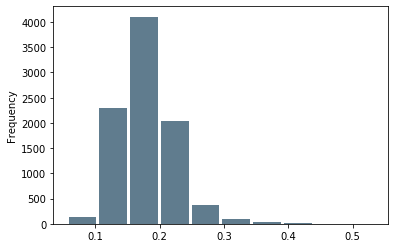

In [37]:
#metrics calculation
cutoff=np.percentile(X_test['HC_SCORE'],95)
ypred=pd.Series(X_test['HC_SCORE']).apply(lambda x : 1 if x >cutoff else 0 )
#ypred=pd.Series(ypred_test).apply(lambda x : 1 if x > 0.48631722 else 0 )

print(confusion_matrix(y_test, ypred))
pd.Series(ypred_test).plot.hist(bins=10, rwidth=0.9 ,color='#607c8e')

print("\n Log Loss is :",log_loss(y_test, ypred_test))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(y_test, ypred_test)))

In [38]:
# retrieve performance metrics
results = bst.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

Text(0.5, 1.0, 'XGBoost AUC')

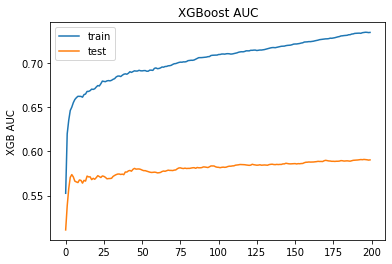

In [39]:
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='train')
ax.plot(x_axis, results['validation_1']['auc'], label='test')

ax.legend()
plt.ylabel('XGB AUC')
plt.title('XGBoost AUC')

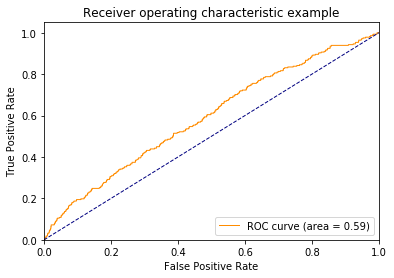

In [40]:
# Compute micro-average ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test.iloc[:, 0].ravel(), ypred_test.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[]

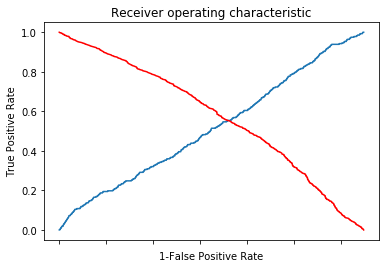

In [41]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.ix[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
ax.set_xticklabels([])

In [42]:
optimal_idx = np.argmax(tpr - fpr)  ## check it once 
optimal_threshold = thresholds[optimal_idx]
print("\n Optimal Cut off :",optimal_threshold)


 Optimal Cut off : 0.16590291


In [43]:
print(" \n Min -Max test score:",test['HC_SCORE'].min(),"\t",test['HC_SCORE'].max())
print(" \n Min -Max train score:",train['HC_SCORE'].min(),"\t",train['HC_SCORE'].max())

 
 Min -Max test score: 0.00033602424136983203 	 0.4294863632786921
 
 Min -Max train score: 0.00028881025456061946 	 0.2871336585693807


In [44]:
## Bad rates in overall population 
cd=pd.DataFrame(df[['HC_SCORE','RISK_FSTQPD30']]).sort_values(by=['HC_SCORE'],ascending=False)
print("\nTotal bad :",df['RISK_FSTQPD30'].sum())
print("Bad captured in worst category :",'{:,.2%}'.format(cd.groupby(pd.qcut(cd['HC_SCORE'],10,duplicates='drop')).sum()['RISK_FSTQPD30'][-1]/df['RISK_FSTQPD30'].sum()))
print("\n",cd.groupby(pd.qcut(cd['HC_SCORE'],10,duplicates='drop')).mean())
print(cd.groupby(pd.qcut(cd['HC_SCORE'],10,duplicates='drop')).sum())


Total bad : 3087
Bad captured in worst category : 29.48%

                      HC_SCORE  RISK_FSTQPD30
HC_SCORE                                    
(-0.000711, 0.0042]  0.002744       0.011817
(0.0042, 0.00655]    0.005384       0.019997
(0.00655, 0.00893]   0.007723       0.018569
(0.00893, 0.0117]    0.010286       0.024023
(0.0117, 0.0153]     0.013481       0.024023
(0.0153, 0.0201]     0.017596       0.030645
(0.0201, 0.0265]     0.023142       0.036234
(0.0265, 0.0361]     0.030892       0.047526
(0.0361, 0.0532]     0.043507       0.069861
(0.0532, 0.505]      0.084577       0.118166
                       HC_SCORE  RISK_FSTQPD30
HC_SCORE                                      
(-0.000711, 0.0042]   21.133724             91
(0.0042, 0.00655]     41.458533            154
(0.00655, 0.00893]    59.472509            143
(0.00893, 0.0117]     79.215832            185
(0.0117, 0.0153]     103.818550            185
(0.0153, 0.0201]     135.506763            236
(0.0201, 0.0265]     178

In [45]:
## Bad rates in overall population 
cd=pd.DataFrame(test[['HC_SCORE','RISK_FSTQPD30']]).sort_values(by=['HC_SCORE'],ascending=False)
print("\nTotal bad :",test['RISK_FSTQPD30'].sum())
print("Bad captured in worst category :",'{:,.2%}'.format(cd.groupby(pd.qcut(cd['HC_SCORE'],10,duplicates='drop')).sum()['RISK_FSTQPD30'][-1]/test['RISK_FSTQPD30'].sum()))
print("\n",cd.groupby(pd.qcut(cd['HC_SCORE'],10,duplicates='drop')).mean())
print(cd.groupby(pd.qcut(cd['HC_SCORE'],10,duplicates='drop')).sum())


Total bad : 270
Bad captured in worst category : 19.63%

                                   HC_SCORE  RISK_FSTQPD30
HC_SCORE                                                 
(-0.0006640000000000001, 0.0025]  0.001697       0.009879
(0.0025, 0.00389]                 0.003186       0.012088
(0.00389, 0.00537]                0.004599       0.024176
(0.00537, 0.00726]                0.006209       0.032967
(0.00726, 0.00972]                0.008405       0.038462
(0.00972, 0.0135]                 0.011495       0.036264
(0.0135, 0.0197]                  0.016359       0.032967
(0.0197, 0.0292]                  0.024132       0.029670
(0.0292, 0.0437]                  0.035776       0.021978
(0.0437, 0.429]                   0.059278       0.058178
                                   HC_SCORE  RISK_FSTQPD30
HC_SCORE                                                  
(-0.0006640000000000001, 0.0025]   1.546006              9
(0.0025, 0.00389]                  2.899301             11
(0.00389,

In [46]:
## Bad rates in overall population 
cdt=pd.DataFrame(outtest[['pred','act']])
print("Bad captured in worst category Partner Score test sample :",'{:,.2%}'.format(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum()['act'][-1]/cdt['act'].sum()))
print("\nTotal bads in test sample:",cdt['act'].sum())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).mean())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum())

Bad captured in worst category Partner Score test sample : 19.42%

Total bads in test sample: 278
                     pred       act
pred                               
(0.0552, 0.133]  0.117604  0.018661
(0.133, 0.145]   0.139510  0.017582
(0.145, 0.155]   0.150260  0.021978
(0.155, 0.165]   0.159763  0.026374
(0.165, 0.175]   0.169708  0.036264
(0.175, 0.184]   0.179086  0.027473
(0.184, 0.196]   0.189571  0.029670
(0.196, 0.212]   0.204528  0.036264
(0.212, 0.235]   0.222487  0.031868
(0.235, 0.534]   0.265186  0.059341
                       pred  act
pred                            
(0.0552, 0.133]  107.137054   17
(0.133, 0.145]   126.954269   16
(0.145, 0.155]   136.736404   20
(0.155, 0.165]   145.384171   24
(0.165, 0.175]   154.433899   33
(0.175, 0.184]   162.968582   25
(0.184, 0.196]   172.509781   27
(0.196, 0.212]   186.120453   33
(0.212, 0.235]   202.463303   29
(0.235, 0.534]   241.319580   54


In [47]:
## Pillar  approach to combine score
hcc_score = 'HC_SCORE'
X_pillar_train = pd.DataFrame()
X_pillar_test = pd.DataFrame()

X_pillar_train[hcc_score]=train['HC_SCORE']; 
X_pillar_test[hcc_score]=test['HC_SCORE']

X_pillar_train["XGB_SCORE"] =  bst.predict_proba(train[selected_vars[0]], ntree_limit=bst.best_ntree_limit)[:, 1]
X_pillar_test["XGB_SCORE"]  =  bst.predict_proba(test[selected_vars[0]], ntree_limit=bst.best_ntree_limit)[:, 1]

X_pillar_train["FSTQ"] = train['RISK_FSTQPD30']
X_pillar_test["FSTQ"] = test['RISK_FSTQPD30']

X_train_log = X_pillar_train.loc[pd.notnull(X_pillar_train[hcc_score]),['HC_SCORE','XGB_SCORE']]
y_train_log = X_pillar_train.loc[pd.notnull(X_pillar_train[hcc_score]),['FSTQ']]

X_test_log = X_pillar_test.loc[pd.notnull(X_pillar_test[hcc_score]),['HC_SCORE','XGB_SCORE']]
y_test_log = X_pillar_test.loc[pd.notnull(X_pillar_test[hcc_score]),['FSTQ']]

X_train_log = np.log((X_train_log + 1e-10).divide(1 - (X_train_log + 1e-10)))
X_test_log = np.log((X_test_log + 1e-10).divide(1 - (X_test_log + 1e-10)))

In [48]:
logreg = LogisticRegression(C=11, n_jobs=cpu)

# cross validation gini
kfolds = StratifiedKFold(10, random_state=1)
auc_cv = cross_val_score(logreg, X_train_log, np.ravel(y_train_log), scoring='roc_auc',
                         cv=kfolds.split(X_test_log, np.ravel(y_test_log)), n_jobs=cpu)
gini_cv = (2 * np.array(auc_cv) - 1).mean()

logreg.fit(X_train_log, np.ravel(y_train_log))
log_coef_tbl = pd.DataFrame({'predictor': ['intercept'] + X_train_log.columns.tolist(),
                             'coefficient': list(logreg.intercept_) + list(logreg.coef_[0])})
log_coef_tbl = log_coef_tbl[['predictor', 'coefficient']]

C:\Users\sgupta\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sgupta\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [49]:
log_coef_tbl

,predictor,coefficient
0,intercept,0.569810
1,HC_SCORE,0.241746
2,XGB_SCORE,2.017730


In [53]:
## Model performance
ypred_train_pillar = logreg.predict_proba(X_train_log)[:, 1]
metric_auc_train_log = metrics.roc_auc_score(np.ravel(y_train_log), ypred_train_pillar)
gini_train_pillar = 2 * metric_auc_train_log - 1
ypred_test_pillar = logreg.predict_proba(X_test_log)[:, 1]
metric_auc_test_log = metrics.roc_auc_score(np.ravel(y_test_log), ypred_test_pillar)
gini_test_pillar = 2 * metric_auc_test_log - 1

print("GINI TRAIN:",gini_train_pillar )
print("GINI TEST:",gini_test_pillar )
print("GINI CV:",gini_cv)

GINI TRAIN: 0.34749361342852314
GINI TEST: 0.3941559312936125
GINI CV: 0.34314705341789586


In [54]:
outtest1=train;  outtest1['pred']=ypred_train_pillar ; outtest1['act']=ypred ; 
outtest1.to_csv(r"clx\\comb_cd_fstq_clx_mix.csv")

C:\Users\sgupta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


[[8429  217]
 [ 403   53]]


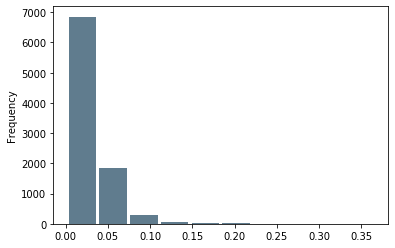

In [58]:
#metrics calculation
cutoff=np.percentile(ypred_test_pillar,95)
ypred=pd.Series(ypred_test_pillar).apply(lambda x : 1 if x >cutoff else 0 )

print(confusion_matrix(ypred,test['RISK_FSTQPD30'] ))
pd.Series(ypred_test_pillar).plot.hist(bins=10, rwidth=0.9 ,color='#607c8e')

In [60]:
print("\n Log Loss is :",log_loss(test['RISK_FSTQPD30'], ypred_test_pillar))
print('Average precision-recall score: {0:0.2f}'.format(average_precision_score(test['RISK_FSTQPD30'], ypred_test_pillar)))


 Log Loss is : 0.12541869121623536
Average precision-recall score: 0.09


In [62]:
len(ypred_test_pillar)

9102

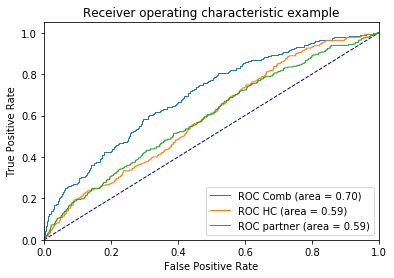

In [63]:
## PRC curve
#precision, recall, _ = precision_recall_curve(ypred, ypred_test_pillar)

# step_kwargs = ({'step': 'post'}
#                #if 'step' in signature(plt.fill_between).parameters
#                #else {}
#               )
# plt.step(recall, precision, color='b', alpha=0.2, where='post')
# plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 0.5])
# plt.xlim([0.0, 0.5])
# plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision_score(test['RISK_FSTQPD30'], ypred_test_pillar)))

# # calculate precision-recall AUC
# auc_pr = auc(recall, precision)
# print("\n AUC for precision-recall :",auc_pr)

# Compute micro-average ROC curve and ROC area
fprhc, tprhc, thresholds = roc_curve(test['RISK_FSTQPD30'], test['HC_SCORE'].ravel())
roc_auchc = auc(fprhc, tprhc)

fprc, tprc, thresholds = roc_curve(test['RISK_FSTQPD30'], ypred_test_pillar.ravel())
roc_aucc = auc(fprc, tprc)

plt.figure()
lw = 1
plt.plot(fprc, tprc, lw=lw, label='ROC Comb (area = %0.2f)' % roc_aucc)
plt.plot(fprhc, tprhc, lw=lw, label='ROC HC (area = %0.2f)' % roc_auchc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr, tpr, lw=lw, label='ROC partner (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [194]:
## Bad rates combined score in overall population 
cdt=pd.DataFrame(outtest1[['pred','act']])
print("Bad captured in worst category Partner Score test sample :",'{:,.2%}'.format(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum()['act'][-1]/cdt['act'].sum()))
print("\nTotal bads in test sample:",cdt['act'].sum())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).mean())
print(cdt.groupby(pd.qcut(cdt['pred'],10,duplicates='drop')).sum())

Bad captured in worst category Partner Score test sample : 27.10%

Total bads in test sample: 1830
                       pred       act
pred                                 
(0.00025, 0.0175]  0.012722  0.015195
(0.0175, 0.0241]   0.020936  0.021216
(0.0241, 0.0302]   0.027165  0.027810
(0.0302, 0.0362]   0.033157  0.027810
(0.0362, 0.0427]   0.039333  0.041284
(0.0427, 0.0503]   0.046346  0.043304
(0.0503, 0.06]     0.054880  0.059346
(0.06, 0.0739]     0.066445  0.067374
(0.0739, 0.0992]   0.084791  0.079128
(0.0992, 0.417]    0.138924  0.142202
                         pred  act
pred                              
(0.00025, 0.0175]   44.376024   53
(0.0175, 0.0241]    73.023346   74
(0.0241, 0.0302]    94.751359   97
(0.0302, 0.0362]   115.653139   97
(0.0362, 0.0427]   137.194985  144
(0.0427, 0.0503]   161.607107  151
(0.0503, 0.06]     191.422315  207
(0.06, 0.0739]     231.761738  235
(0.0739, 0.0992]   295.749518  276
(0.0992, 0.417]    484.567164  496
